1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2022-11-25 11:10:34--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2022-11-25 11:10:35--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc977c0b0a6cf6570f0b51e1a9d0.dl.dropboxusercontent.com/cd/0/inline/BxZ9Dn65eK4ofxsh4EJxmgx6XcRRp6jwK3upS8Z0FgiRAUy7w1o4SP9Y1lVRPoy6j-MzTiuveiMFdhRaMN0P4h8GwJOhP0krZXVY6XeJoMbmjrUjbpTHRpMQCXOjKxYEYE6pXUR-o-XvM349PL7zAV3lq_GUb28RLbGN1rjbyr68pg/file# [following]
--2022-11-25 11:10:35--  https://uc977c0b0a6cf6570f0b51e1a9d0.dl.dropboxusercontent.com/cd/0/inline/BxZ9Dn65eK4ofxsh4EJxmgx6XcRRp6jwK3upS8Z0FgiRAUy7w1o4SP9Y1lVRPoy6j-Mz

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
N = 10001
file = "./data/data_000637.txt"
df_n = pd.read_csv(file, nrows=N)

df= pd.read_csv(file)
data=pd.DataFrame(df_n)
#data_frame=pd.DataFrame(df)
#data_frame
data # with 10001 rows

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15
9999,1,0,49,3869200267,777,13


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
max_value = data["BX_COUNTER"].max()
max_value
print("BX counter reaches the maximum value before being reset to 0 is :",max_value)

BX counter reaches the maximum value before being reset to 0 is : 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [7]:
#timing information is a addition of the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS')
#Create a new column with the absolute time in ns 
#(as a combination of the other three columns with timing information)
from datetime import datetime, timedelta
df['ABS_TIME']  = df.apply(lambda row: row.ORBIT_CNT + row.BX_COUNTER + row.TDC_MEAS, axis=1)
df['ABS_TIME'] = pd.to_datetime(df['ABS_TIME'])
#df['ABS_TIME'] = df['ABS_TIME'].astype('datetime64[ns]')
data['ABS_TIME']  = data.apply(lambda row: row.ORBIT_CNT + row.BX_COUNTER + row.TDC_MEAS, axis=1)
data['ABS_TIME'] = pd.to_datetime(data['ABS_TIME'])

data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,1970-01-01 00:00:03.869202567
1,1,0,124,3869200167,2374,27,1970-01-01 00:00:03.869202568
2,1,0,63,3869200167,2553,28,1970-01-01 00:00:03.869202748
3,1,0,64,3869200167,2558,19,1970-01-01 00:00:03.869202744
4,1,0,64,3869200167,2760,25,1970-01-01 00:00:03.869202952
...,...,...,...,...,...,...,...
9996,1,0,60,3869200267,701,5,1970-01-01 00:00:03.869200973
9997,1,0,59,3869200267,707,23,1970-01-01 00:00:03.869200997
9998,1,0,63,3869200267,706,15,1970-01-01 00:00:03.869200988
9999,1,0,49,3869200267,777,13,1970-01-01 00:00:03.869201057


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [8]:
df['ABS_NEWDUR'] = df['ABS_TIME'].dt.strftime('%H:%M:%S')
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME,ABS_NEWDUR
0,1,0,123.0,3.869200e+09,2374.0,26.0,1970-01-01 00:00:03.869202567,00:00:03
1,1,0,124.0,3.869200e+09,2374.0,27.0,1970-01-01 00:00:03.869202568,00:00:03
2,1,0,63.0,3.869200e+09,2553.0,28.0,1970-01-01 00:00:03.869202748,00:00:03
3,1,0,64.0,3.869200e+09,2558.0,19.0,1970-01-01 00:00:03.869202744,00:00:03
4,1,0,64.0,3.869200e+09,2760.0,25.0,1970-01-01 00:00:03.869202952,00:00:03
...,...,...,...,...,...,...,...,...
1564592,1,0,62.0,3.869211e+09,762.0,14.0,1970-01-01 00:00:03.869211947,00:00:03
1564593,1,1,4.0,3.869211e+09,763.0,11.0,1970-01-01 00:00:03.869211945,00:00:03
1564594,1,0,64.0,3.869211e+09,764.0,0.0,1970-01-01 00:00:03.869211935,00:00:03
1564595,1,0,139.0,3.869211e+09,769.0,0.0,1970-01-01 00:00:03.869211940,00:00:03


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [21]:
noisy_channels=data['TDC_CHANNEL'].value_counts(ascending=False)
print("The channels with most noise:\n",noisy_channels.head(3))

The channels with most noise:
 139    860
63     499
64     491
Name: TDC_CHANNEL, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [23]:
non_empty=df.groupby(['ORBIT_CNT']).count() # count drops null and empty values
no_of_orbits=len(non_empty)
print("the number of orbits with at least one hit: ",no_of_orbits)

the number of orbits with at least one hit:  11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [25]:
orbits=df[df['TDC_CHANNEL']==139] # making a dataframe with at least one measurement from TDC_CHANNEL=139.
unique=len(orbits.groupby('ORBIT_CNT').count()) #grouping by ORBIT_CNT and calculating length
print("the no. of unique orbits with at least one measurement from TDC_CHANNEL=139 :",unique)
orbits

the no. of unique orbits with at least one measurement from TDC_CHANNEL=139 : 10976


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME,ABS_NEWDUR
7,1,0,139.0,3.869200e+09,2776.0,0.0,1970-01-01 00:00:03.869202943,00:00:03
15,1,1,139.0,3.869200e+09,2797.0,0.0,1970-01-01 00:00:03.869202964,00:00:03
30,1,0,139.0,3.869200e+09,3085.0,0.0,1970-01-01 00:00:03.869203252,00:00:03
39,1,0,139.0,3.869200e+09,3186.0,0.0,1970-01-01 00:00:03.869203353,00:00:03
48,1,0,139.0,3.869200e+09,23.0,0.0,1970-01-01 00:00:03.869200191,00:00:03
...,...,...,...,...,...,...,...,...
1564527,1,1,139.0,3.869211e+09,2959.0,0.0,1970-01-01 00:00:03.869214129,00:00:03
1564537,1,0,139.0,3.869211e+09,3027.0,0.0,1970-01-01 00:00:03.869214197,00:00:03
1564562,1,0,139.0,3.869211e+09,3230.0,0.0,1970-01-01 00:00:03.869214400,00:00:03
1564578,1,0,139.0,3.869211e+09,21.0,0.0,1970-01-01 00:00:03.869211192,00:00:03


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [26]:
# create FPGA1 series
series_0 = df[df['FPGA'] == 0]# making a dataframe of FPGA=0
FPGA_0 = pd.Series(series_0[['TDC_CHANNEL']].value_counts()) # number of counts for the corresponding TDC channel 
print("THE FPGA = 0 is :\n", FPGA_0)
# create FPGA2 series
series_1=df[df['FPGA'] == 1] # making a dataframe of FPGA=1
FPGA_1 = pd.Series(series_1[['TDC_CHANNEL']].value_counts()) # number of counts for the corresponding TDC channel 
print("THE FPGA = 1 is : \n", FPGA_1)

THE FPGA = 0 is :
 TDC_CHANNEL
139.0          90093
64.0           77281
63.0           76141
61.0           58059
62.0           57660
               ...  
138.0             41
137.0             39
30.0               5
129.0              2
39.0               1
Length: 124, dtype: int64
THE FPGA = 1 is : 
 TDC_CHANNEL
2.0            39051
139.0          38676
1.0            33997
4.0            31587
3.0            26246
               ...  
9.0               93
130.0             45
137.0             43
138.0             43
129.0             42
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

<AxesSubplot:ylabel='Frequency'>

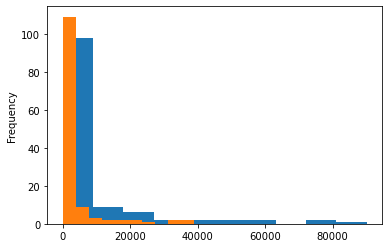

In [27]:
FPGA_0.plot(kind='hist')
FPGA_1.plot(kind='hist')